<a href="https://colab.research.google.com/github/samservo09/thesis-svm-tele-triage/blob/main/Final_SVM_RoBERTa_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv',
                 quoting=1,
                 escapechar='\\',
                 doublequote=True)

df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000,
                       stop_words='english',
                       ngram_range=(1, 2))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['Post'],
    df['Label'],
    test_size=0.2,
    random_state=42
)

# Create TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Handle class imbalance (if any)
# Compute class weights for imbalanced classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 20.0),  # Try larger range
    'class_weight': ['balanced', None],  # Try both balanced and None for better optimization
    'dual': [True, False],
    'max_iter': randint(500, 10000),
    'tol': uniform(1e-5, 1e-1)
}

# Create RandomizedSearchCV
svm = LinearSVC(class_weight='balanced')  # Keep class_weight='balanced' to handle imbalance
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,  # Increase the number of iterations for better tuning
    cv=10,
    scoring='f1_macro',  # F1 score is good for imbalanced classes
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_tfidf, y_train)

# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print top features for each class
def print_top_features(vectorizer, clf, class_labels, n=10):
    feature_names = vectorizer.get_feature_names_out()
    best_estimator = clf.best_estimator_
    for i, label in enumerate(class_labels):
        top_indices = np.argsort(best_estimator.coef_[i])[-n:]
        print(f"\nTop {n} features for {label}:")
        for idx in reversed(top_indices):
            print(f"{feature_names[idx]}: {best_estimator.coef_[i][idx]:.4f}")

classes = sorted(df['Label'].unique())
print("\nTop features per class:")
print_top_features(tfidf, random_search, classes)

--2025-02-27 13:38:42--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.06s   

2025-02-27 13:38:43 (56.9 MB/s) - ‘500_Reddit_users_posts_labels.csv’ saved [3622335/3622335]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Parameters: {'C': 0.6070148683091502, 'class_weight': 'balanced', 'dual': False, 'max_iter': 3338, 'tol': 0.04284144749401078}
Best Cross-Validation Score: 0.2955628680352421

Classification Report:
              precision    recall  f1-score   supp

In [4]:
import pickle

# Create a dictionary to store important objects
model_data = {
    "tfidf_vectorizer": tfidf,
    "random_search": random_search,
    "class_weight_dict": class_weight_dict,
    "X_test_tfidf": X_test_tfidf,
    "y_test": y_test
}

# Save the dictionary into a pickle file
with open("svm_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model and related objects saved successfully!")

Model and related objects saved successfully!


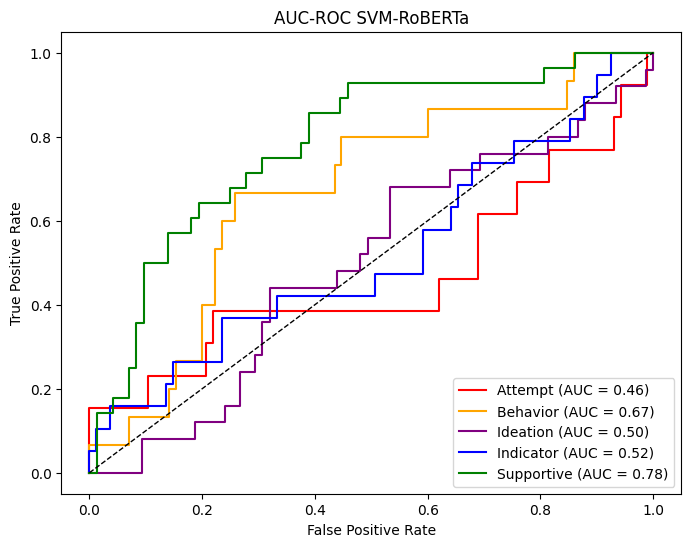

In [ ]:
#AUC-ROC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import uniform, randint

# Binarize the output labels for multi-class ROC
classes = sorted(df['Label'].unique())  # Get class labels
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# Get decision function scores from the trained model
y_scores = random_search.decision_function(X_test_tfidf)

# Plot AUC-ROC curves for each class
plt.figure(figsize=(8, 6))

colors = ["red", "orange", "purple", "blue", "green"]
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC SVM-RoBERTa")
plt.legend(loc="lower right")
plt.show()

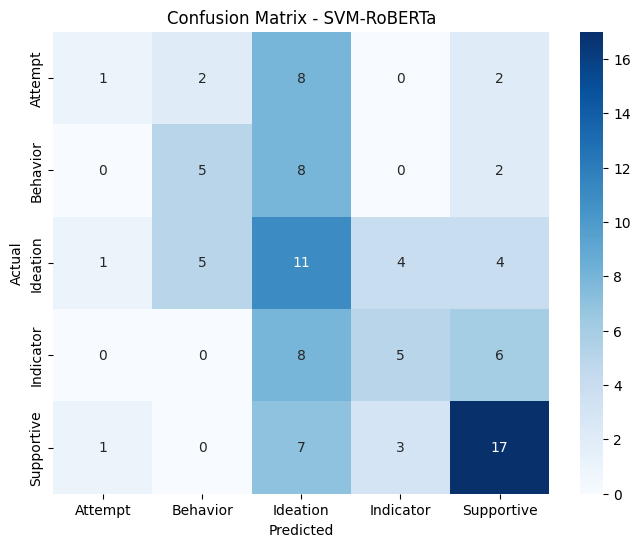

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM-RoBERTa')
plt.show()


### with textgcn

In [ ]:
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Load and clean data (Add these lines to reload the dataframe)
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv',
                 quoting=1,
                 escapechar='\\',
                 doublequote=True)

df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Step 1: Generate Emotion Embeddings with TextGCN or Use Pre-trained Emotion Lexicons
class EmotionEmbeddingExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_dim=300):
        self.embedding_dim = embedding_dim
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bert = BertModel.from_pretrained("bert-base-uncased")

    def fit(self, X, y=None):
        # No fitting required for BERT-based embeddings
        return self

    def transform(self, X):
        emotion_embeddings = []
        for text in X:
            tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = self.bert(**tokens)
            # Pooler output or mean pooling over token embeddings
            embedding = outputs.pooler_output.mean(dim=0).numpy()
            emotion_embeddings.append(embedding)
        return np.array(emotion_embeddings)

# Step 2: Combine TF-IDF with Emotion Features
class FeatureCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, tfidf, emotion_extractor):
        self.tfidf = tfidf
        self.emotion_extractor = emotion_extractor

    def fit(self, X, y=None):
        self.tfidf.fit(X, y)
        self.emotion_extractor.fit(X, y)
        return self

    def transform(self, X):
        tfidf_features = self.tfidf.transform(X).toarray()
        emotion_features = self.emotion_extractor.transform(X)
        combined_features = np.hstack((tfidf_features, emotion_features))
        return combined_features

# Create TF-IDF and Emotion Extractor
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
emotion_extractor = EmotionEmbeddingExtractor(embedding_dim=768)

# Combine Features
feature_combiner = FeatureCombiner(tfidf, emotion_extractor)

# Step 3: Train-Test Split and Transformation
X_train, X_test, y_train, y_test = train_test_split(
    df['Post'],
    df['Label'],
    test_size=0.2,
    random_state=42
)

X_train_combined = feature_combiner.fit_transform(X_train)
X_test_combined = feature_combiner.transform(X_test)

# Step 4: SVM Training with Combined Features
svm = LinearSVC(class_weight='balanced')

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 20.0),
    'class_weight': ['balanced', None],
    'dual': [True, False],
    'max_iter': randint(500, 10000),
    'tol': uniform(1e-5, 1e-1)
}

random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_combined, y_train)

# Evaluate Model
y_pred = random_search.predict(X_test_combined)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

--2024-11-27 05:37:31--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.1’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 05:37:31 (125 MB/s) - ‘500_Reddit_users_posts_labels.csv.1’ saved [3622335/3622335]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Classification Report:
              precision    recall  f1-score   support

     Attempt       0.00      0.00      0.00        13
    Behavior       0.31      0.33      0.32        15
    Ideation       0.22      0.16      0.19        25
   Indicato

### nltk tf-idf

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, confusion_matrix

# Download necessary NLTK packages (ensure this only runs once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv',
                 quoting=1,
                 escapechar='\\',
                 doublequote=True)

df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Define stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]  # Remove stop words and non-alphanumeric
    return ' '.join(tokens)

df['Post'] = df['Post'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['Post'],
    df['Label'],
    test_size=0.2,
    random_state=42
)

# Generate TF-IDF features using NLTK
# Step 1: Create a term-document matrix using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Step 2: Compute TF-IDF values
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Handle class imbalance (if any)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 20.0),
    'class_weight': ['balanced', None],
    'dual': [True, False],
    'max_iter': randint(500, 10000),
    'tol': uniform(1e-5, 1e-1)
}

# Create and train the SVM model
svm = LinearSVC(class_weight='balanced')
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)

# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print top features for each class
def print_top_features(vectorizer, clf, class_labels, n=10):
    feature_names = vectorizer.get_feature_names_out()
    best_estimator = clf.best_estimator_
    for i, label in enumerate(class_labels):
        top_indices = np.argsort(best_estimator.coef_[i])[-n:]
        print(f"\nTop {n} features for {label}:")
        for idx in reversed(top_indices):
            print(f"{feature_names[idx]}: {best_estimator.coef_[i][idx]:.4f}")

classes = sorted(df['Label'].unique())
print("\nTop features per class:")
print_top_features(vectorizer, random_search, classes)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--2024-11-27 05:59:28--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.3’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 05:59:28 (120 MB/s) - ‘500_Reddit_users_posts_labels.csv.3’ saved [3622335/3622335]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Parameters: {'C': 0.40609080580769497, 'class_weight': 'balanced', 'dual': False, 'max_iter': 9707, 'tol': 0.0658793631618945}
Best Cross-Validation Score: 0.2905183406655863

Classification Report:
              precision    recall  f1-score   s

### emtion embedding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
import torch
from transformers import BertTokenizer, BertModel

# Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv',
                 quoting=1,
                 escapechar='\\',
                 doublequote=True)

df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['Post'],
    df['Label'],
    test_size=0.2,
    random_state=42
)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000,
                        stop_words='english',
                        ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Generate Emotion Embeddings using BERT
class EmotionEmbeddingExtractor:
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)

    def extract(self, texts):
        embeddings = []
        for text in texts:
            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Use the mean pooling of the last hidden state
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
        return np.array(embeddings)

# Instantiate the emotion embedding extractor
emotion_extractor = EmotionEmbeddingExtractor()

# Generate emotion embeddings
X_train_emotion = emotion_extractor.extract(X_train)
X_test_emotion = emotion_extractor.extract(X_test)

# Combine TF-IDF features with emotion embeddings
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_emotion))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_emotion))

# Handle class imbalance (if any)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 20.0),
    'class_weight': ['balanced', None],
    'dual': [True, False],
    'max_iter': randint(500, 10000),
    'tol': uniform(1e-5, 1e-1)
}

# Create and train the SVM model
svm = LinearSVC(class_weight='balanced')
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_combined, y_train)

# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test_combined)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print top features for each class
def print_top_features(vectorizer, clf, class_labels, n=10):
    feature_names = vectorizer.get_feature_names_out()
    best_estimator = clf.best_estimator_
    for i, label in enumerate(class_labels):
        top_indices = np.argsort(best_estimator.coef_[i])[-n:]
        print(f"\nTop {n} features for {label}:")
        for idx in reversed(top_indices):
            print(f"{feature_names[idx]}: {best_estimator.coef_[i][idx]:.4f}")

classes = sorted(df['Label'].unique())
print("\nTop features per class:")
print_top_features(tfidf, random_search, classes)


--2024-11-27 06:05:44--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.4’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 06:05:44 (104 MB/s) - ‘500_Reddit_users_posts_labels.csv.4’ saved [3622335/3622335]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Parameters: {'C': 7.101568153893513, 'class_weight': 'balanced', 'dual': False, 'max_iter': 7522, 'tol': 0.049261769381886394}
Best Cross-Validation Score: 0.3899745711726936

Classification Report:
              precision    recall  f1-score   s

IndexError: index 5032 is out of bounds for axis 0 with size 5000

### gensim tf-idf

In [ ]:
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv',
                 quoting=1,
                 escapechar='\\',
                 doublequote=True)

df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Tokenization and Preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    return tokens

df['Processed_Post'] = df['Post'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed_Post'],
    df['Label'],
    test_size=0.2,
    random_state=42
)

# Create Gensim Dictionary and Corpus
dictionary = Dictionary(X_train)
corpus_train = [dictionary.doc2bow(text) for text in X_train]
corpus_test = [dictionary.doc2bow(text) for text in X_test]

# Train Gensim TF-IDF Model
tfidf_model = TfidfModel(corpus_train)

# Convert TF-IDF Corpus to Dense Numpy Arrays
def get_dense_tfidf(corpus, tfidf_model, dictionary):
    tfidf_corpus = tfidf_model[corpus]
    dense_matrix = corpus2dense(tfidf_corpus, num_terms=len(dictionary)).T
    return dense_matrix

X_train_tfidf = get_dense_tfidf(corpus_train, tfidf_model, dictionary)
X_test_tfidf = get_dense_tfidf(corpus_test, tfidf_model, dictionary)

# Handle class imbalance (if any)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 20.0),
    'class_weight': ['balanced', None],
    'dual': [True, False],
    'max_iter': randint(500, 10000),
    'tol': uniform(1e-5, 1e-1)
}

# Create and train the SVM model
svm = LinearSVC(class_weight='balanced')
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_tfidf, y_train)

# Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Evaluate on test set
y_pred = random_search.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--2024-11-27 06:13:04--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.5’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 06:13:04 (102 MB/s) - ‘500_Reddit_users_posts_labels.csv.5’ saved [3622335/3622335]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Parameters: {'C': 1.0290082543999546, 'class_weight': 'balanced', 'dual': True, 'max_iter': 5893, 'tol': 0.09489855372533333}
Best Cross-Validation Score: 0.2540268061514828

Classification Report:
              precision    recall  f1-score   su

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### with smote

In [ ]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Using imbalanced-learn's Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import uniform, randint
import pandas as pd
import numpy as np

# Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv', quoting=1, escapechar='\\', doublequote=True)

df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['Label'], test_size=0.2, random_state=42)

# Create TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Handle class imbalance (if any) using SMOTE
smote = SMOTE(random_state=42)

# Create the base SVM model
svm = LinearSVC(class_weight='balanced')

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': uniform(0.1, 20.0),  # Try larger range
    'class_weight': ['balanced', None],  # Try both balanced and None for better optimization
    'dual': [True, False],
    'max_iter': randint(500, 10000),
    'tol': uniform(1e-5, 1e-1)
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,  # Increase the number of iterations for better tuning
    cv=10,
    scoring='f1_macro',  # F1 score is good for imbalanced classes
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Create a pipeline that includes TF-IDF transformation, SMOTE, and SVM model
pipeline = ImbPipeline([
    ('tfidf', tfidf),  # TF-IDF vectorizer
    ('smote', smote),  # Apply SMOTE to oversample the minority class
    ('svm', random_search)  # SVM with RandomizedSearchCV
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("\nBest Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Evaluate on test set
y_pred = pipeline.predict(X_test)

# Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print top features for each class
def print_top_features(vectorizer, clf, class_labels, n=10):
    feature_names = vectorizer.get_feature_names_out()
    best_estimator = clf.best_estimator_
    for i, label in enumerate(class_labels):
        top_indices = np.argsort(best_estimator.coef_[i])[-n:]
        print(f"\nTop {n} features for {label}:")
        for idx in reversed(top_indices):
            print(f"{feature_names[idx]}: {best_estimator.coef_[i][idx]:.4f}")

classes = sorted(df['Label'].unique())
print("\nTop features per class:")
print_top_features(tfidf, random_search, classes)

--2024-11-27 06:31:04--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.7’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 06:31:04 (119 MB/s) - ‘500_Reddit_users_posts_labels.csv.7’ saved [3622335/3622335]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best Parameters: {'C': 19.408387025775873, 'class_weight': 'balanced', 'dual': True, 'max_iter': 7658, 'tol': 0.033912979104870074}
Best Cross-Validation Score: 0.8310313313955217

Classification Report:
              precision    recall  f1-score   s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### distilbert

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Step 1: Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv', quoting=1, escapechar='\\', doublequote=True)

# Clean text data (remove unwanted characters)
df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['Label'], test_size=0.2, random_state=42)

# Step 3: Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check if GPU is available and move model to device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 4: Create a function to generate embeddings for each post
def get_bert_embeddings(posts):
    embeddings = []
    for post in posts:
        # Tokenize and encode the post
        inputs = tokenizer(post, return_tensors='pt', truncation=True, padding=True, max_length=512)
        # Move tensors to the appropriate device (GPU or CPU)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Get the embeddings from BERT (last hidden state)
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Average the token embeddings to get a single vector representation for the post
        post_embedding = last_hidden_state.mean(dim=1).cpu().numpy()  # Shape: (batch_size, hidden_size)
        embeddings.append(post_embedding)

    return np.vstack(embeddings)

# Step 5: Apply this function to your dataset to generate embeddings
X_train_embeddings = get_bert_embeddings(X_train)
X_test_embeddings = get_bert_embeddings(X_test)

# Step 6: Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace missing values with the mean of the column

# Step 7: Create a pipeline with imputation and SVM classifier
svm = SVC(kernel='linear', class_weight='balanced')  # SVM with balanced class weights

# Create a pipeline to apply imputation and then train the SVM model
pipeline = make_pipeline(imputer, svm)

# Step 8: Train the model using the pipeline
pipeline.fit(X_train_embeddings, y_train)

# Step 9: Make predictions and evaluate
y_pred = pipeline.predict(X_test_embeddings)

# Step 10: Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

--2024-11-27 06:40:26--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.9’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 06:40:26 (117 MB/s) - ‘500_Reddit_users_posts_labels.csv.9’ saved [3622335/3622335]


Classification Report:
              precision    recall  f1-score   support

     Attempt       0.00      0.00      0.00        13
    Behavior       0.32      0.40      0.35        15
    Ideation       0.22      0.24      0.23        25
   Indicator       0.17      0.21      0.19        19
  Supportive       0.5

### roberta with pca

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from transformers import RobertaTokenizer, RobertaModel
import torch

# Step 1: Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv', quoting=1, escapechar='\\', doublequote=True)

# Clean text data (remove unwanted characters)
df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['Label'], test_size=0.2, random_state=42)

# Step 3: Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Check if GPU is available and move model to device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 4: Create a function to generate embeddings for each post using RoBERTa
def get_roberta_embeddings(posts):
    embeddings = []
    for post in posts:
        # Tokenize and encode the post
        inputs = tokenizer(post, return_tensors='pt', truncation=True, padding=True, max_length=512)
        # Move tensors to the appropriate device (GPU or CPU)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Get the embeddings from RoBERTa (last hidden state)
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Average the token embeddings to get a single vector representation for the post
        post_embedding = last_hidden_state.mean(dim=1).cpu().numpy()  # Shape: (batch_size, hidden_size)
        embeddings.append(post_embedding)

    return np.vstack(embeddings)

# Step 5: Apply this function to your dataset to generate embeddings
X_train_embeddings = get_roberta_embeddings(X_train)
X_test_embeddings = get_roberta_embeddings(X_test)

# Step 6: Apply PCA for dimensionality reduction (reduce to, e.g., 300 dimensions)
pca = PCA(n_components=300)  # You can adjust the number of components here
X_train_pca = pca.fit_transform(X_train_embeddings)
X_test_pca = pca.transform(X_test_embeddings)

# Step 7: Handle class imbalance (if any) and compute class weights for imbalanced classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Step 8: Define parameter distributions for RandomizedSearchCV (for hyperparameter tuning)
from scipy.stats import uniform, randint
param_distributions = {
    'C': uniform(0.1, 20.0),
    'class_weight': ['balanced', None],  # Try both balanced and None for better optimization
    'kernel': ['rbf'],  # RBF kernel
    'gamma': ['scale', 'auto'],
    'tol': uniform(1e-5, 1e-1)
}

# Step 9: Create RandomizedSearchCV
svm = SVC()  # Use SVM with RBF kernel
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,  # Increase the number of iterations for better tuning
    cv=5,
    scoring='f1_macro',  # F1 score is good for imbalanced classes
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Step 10: Fit RandomizedSearchCV
random_search.fit(X_train_pca, y_train)

# Step 11: Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Step 12: Evaluate on test set
y_pred = random_search.predict(X_test_pca)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 13: Print top features for each class (optional, as SVM is using kernel)
# This step may not be as meaningful with an RBF kernel, but for linear models, it shows top features.
# def print_top_features(vectorizer, clf, class_labels, n=10):
#     feature_names = vectorizer.get_feature_names_out()
#     best_estimator = clf.best_estimator_
#     for i, label in enumerate(class_labels):
#         top_indices = np.argsort(best_estimator.coef_[i])[-n:]
#         print(f"\nTop {n} features for {label}:")
#         for idx in reversed(top_indices):
#             print(f"{feature_names[idx]}: {best_estimator.coef_[i][idx]:.4f}")

# classes = sorted(df['Label'].unique())
# print("\nTop features per class:")
# print_top_features(tfidf, random_search, classes)


--2024-11-27 07:31:44--  https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3622335 (3.5M) [text/plain]
Saving to: ‘500_Reddit_users_posts_labels.csv.10’

500_Reddit_users_po 100%[===================>]   3.45M  --.-KB/s    in 0.03s   

2024-11-27 07:31:44 (114 MB/s) - ‘500_Reddit_users_posts_labels.csv.10’ saved [3622335/3622335]



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'C': 2.918484499495253, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.007465064367977082}
Best Cross-Validation Score: 0.325149631666925

Classification Report:
              precision    recall  f1-score   support

     Attempt       0.33      0.08      0.12        13
    Behavior       0.31      0.27      0.29        15
    Ideation       0.31      0.44      0.37        25
   Indicator       0.32      0.37      0.34        19
  Supportive       0.59      0.57      0.58        28

    accuracy                           0.39       100
   macro avg       0.37      0.34      0.34       100
weighted avg       0.39      0.39      0.38       100


Confusion Matrix:
[[ 1  4  6  0  2]
 [ 1  4  6  2  2]
 [ 1  3 11  5  5]
 [ 0  1  9  7  2]
 [ 0  1  3  8 16]]


In [ ]:
import torch
from transformers import DisorBertTokenizer, DisorBertModel  # Assuming DisorBERT is available
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Step 1: Load and clean data
!wget https://raw.githubusercontent.com/samservo09/thesis-svm-tele-triage/refs/heads/main/data/500_Reddit_users_posts_labels.csv
df = pd.read_csv('500_Reddit_users_posts_labels.csv', quoting=1, escapechar='\\', doublequote=True)

# Clean text data (remove unwanted characters)
df['Post'] = df['Post'].str.replace(r'[\[\]\'"]', '', regex=True)

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['Label'], test_size=0.2, random_state=42)

# Step 3: Load DisorBERT tokenizer and model
tokenizer = DisorBertTokenizer.from_pretrained('disorbert-base')  # Use the correct identifier for DisorBERT
model = DisorBertModel.from_pretrained('disorbert-base')  # Same here

# Check if GPU is available and move model to device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Step 4: Create a function to generate embeddings for each post using DisorBERT
def get_disorbert_embeddings(posts):
    embeddings = []
    for post in posts:
        # Tokenize and encode the post
        inputs = tokenizer(post, return_tensors='pt', truncation=True, padding=True, max_length=512)
        # Move tensors to the appropriate device (GPU or CPU)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Get the embeddings from DisorBERT (last hidden state)
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Average the token embeddings to get a single vector representation for the post
        post_embedding = last_hidden_state.mean(dim=1).cpu().numpy()  # Shape: (batch_size, hidden_size)
        embeddings.append(post_embedding)

    return np.vstack(embeddings)

# Step 5: Apply this function to your dataset to generate embeddings
X_train_embeddings = get_disorbert_embeddings(X_train)
X_test_embeddings = get_disorbert_embeddings(X_test)

# Step 6: Apply PCA for dimensionality reduction (reduce to, e.g., 300 dimensions)
pca = PCA(n_components=300)  # You can adjust the number of components here
X_train_pca = pca.fit_transform(X_train_embeddings)
X_test_pca = pca.transform(X_test_embeddings)

# Step 7: Handle class imbalance (if any) and compute class weights for imbalanced classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Step 8: Define parameter distributions for RandomizedSearchCV (for hyperparameter tuning)
param_distributions = {
    'C': uniform(0.1, 20.0),
    'class_weight': ['balanced', None],  # Try both balanced and None for better optimization
    'kernel': ['rbf'],  # RBF kernel
    'gamma': ['scale', 'auto'],
    'tol': uniform(1e-5, 1e-1)
}

# Step 9: Create RandomizedSearchCV
svm = SVC()  # Use SVM with RBF kernel
random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_distributions,
    n_iter=100,  # Increase the number of iterations for better tuning
    cv=5,
    scoring='f1_macro',  # F1 score is good for imbalanced classes
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Step 10: Fit RandomizedSearchCV
random_search.fit(X_train_pca, y_train)

# Step 11: Print best parameters and score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Step 12: Evaluate on test set
y_pred = random_search.predict(X_test_pca)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


ImportError: cannot import name 'DisorBertTokenizer' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)